In [2]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 1

In [4]:
import sys
import os 
sys.path.append('../src/detectron2/projects/DensePose')

In [5]:
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd

import numpy as np
import cv2

from sklearn.model_selection import KFold, cross_val_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC, SVR

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_histogram



from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding
from sklearn.pipeline import Pipeline

from src.utils.feats import load_gei
from src.utils.plot_config import set_plot_config
from src.utils.results import df_results
from src.utils.bayes_optim import bayes_search

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



# Plots

In [3]:
set_plot_config()

In [9]:
# load
datapath = "../data/feats/database24_gei_480x640.pkl"

dim = (32, 24)
crop_person = True

X, y = load_gei(datapath, dim=dim, crop_person=crop_person)     

In [10]:
def plot2d(X_trans, y):
    plt.figure(figsize=(10,8))
    plt.scatter(X_trans[:,0], X_trans[:,1], c=y, cmap=plt.cm.jet)
    
    plt.xlabel('$x_1$')    
    plt.ylabel('$x_2$')
    
    plt.show()
    
    
def plot3d(X_trans, y):
    
    
    fig = plt.figure(1, figsize=(8, 6))
    ax = Axes3D(fig, elev=-150, azim=110)

    ax.scatter(X_trans[:, 0], X_trans[:, 1], X_trans[:, 2], c=y,
               cmap=plt.cm.jet, edgecolor='k', s=40)
    
    ax.set_xlabel("$x_1$")
    ax.w_xaxis.set_ticklabels([])
    
    ax.set_ylabel("$x_2$")
    ax.w_yaxis.set_ticklabels([])
    
    ax.set_zlabel("$x_3$")
    ax.w_zaxis.set_ticklabels([])
    
    
    
    
#     ax = plt.figure(figsize=(10,8)).gca(projection='3d')    
    
#     ax.scatter(xs=X_trans[:,0], ys=X_trans[:,1], zs=X_trans[:,2], c=y, cmap=plt.cm.jet)
#     ax.set_xlabel('$x_1$')
#     ax.set_ylabel('$x_2$')
#     ax.set_zlabel('$x_3$')
    
    plt.show()
    
    

## SVD

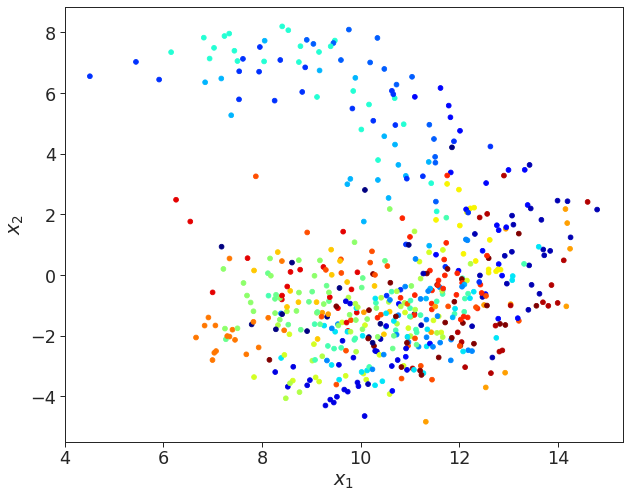

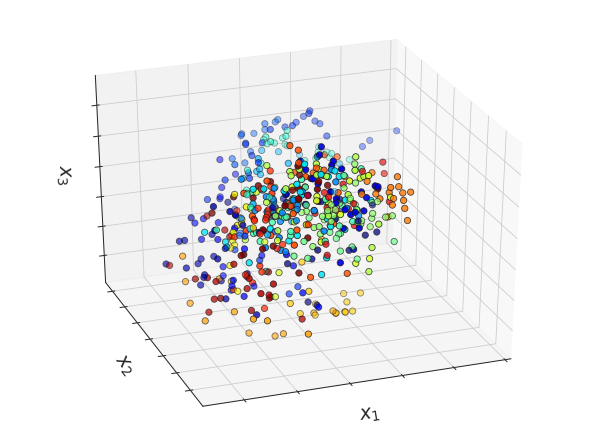

In [6]:
X, y = load_gei(datapath, dim=dim, crop_person=crop_person)     
plot2d(TruncatedSVD(n_components=2).fit_transform(X), y)
plot3d(TruncatedSVD(n_components=3).fit_transform(X), y)

## PCA

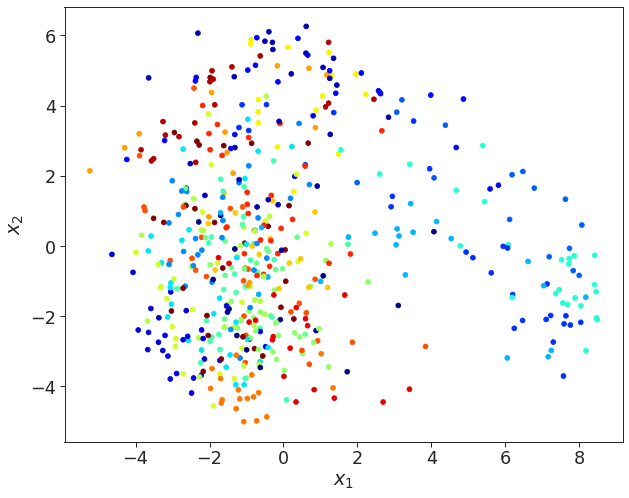

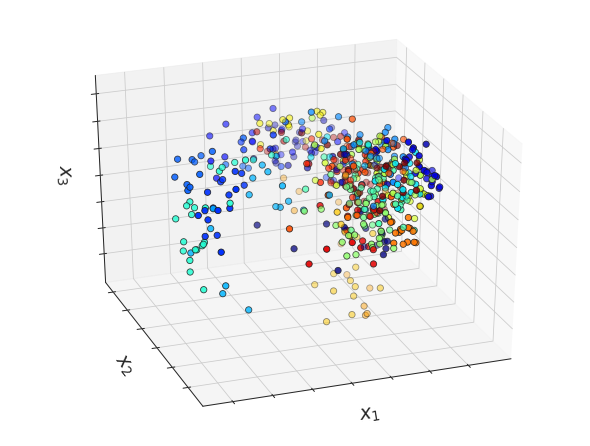

In [7]:
X, y = load_gei(datapath, dim=dim, crop_person=crop_person)     
plot2d(PCA(n_components=2).fit_transform(X), y)
plot3d(PCA(n_components=3).fit_transform(X), y)

## LDA

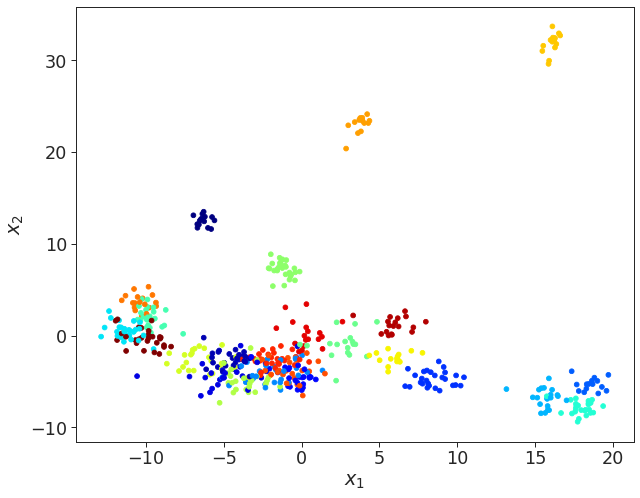

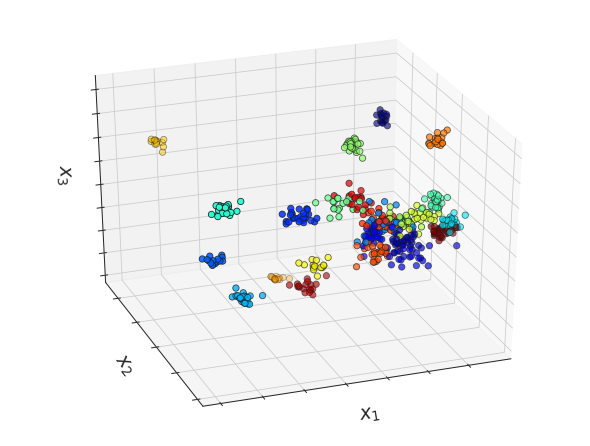

In [8]:
X, y = load_gei(datapath, dim=dim, crop_person=crop_person)     
plot2d(LDA(n_components=2).fit_transform(X, y),y)
plot3d(LDA(n_components=3).fit_transform(X, y),y)

## T-SNE

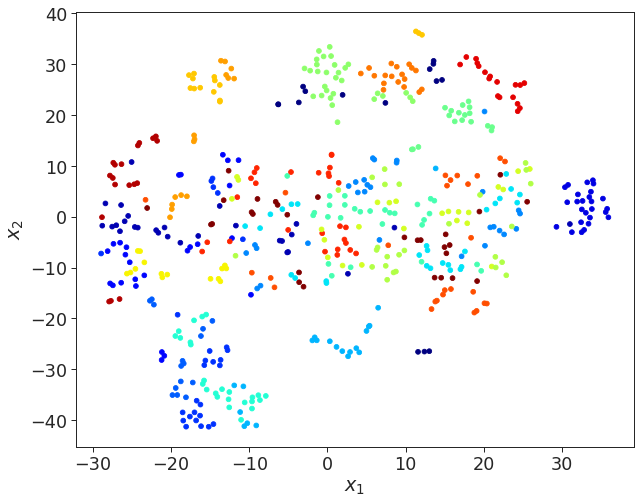

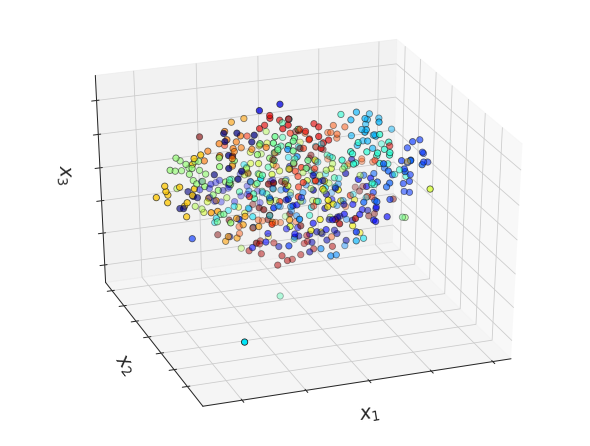

In [9]:
X, y = load_gei(datapath, dim=dim, crop_person=crop_person)     
plot2d(TSNE(n_components=2).fit_transform(X),y)     
plot3d(TSNE(n_components=3).fit_transform(X),y)

## Isomap Embedding

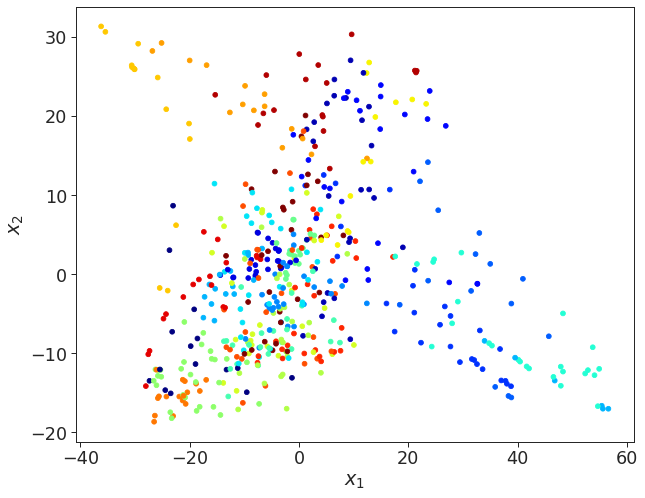

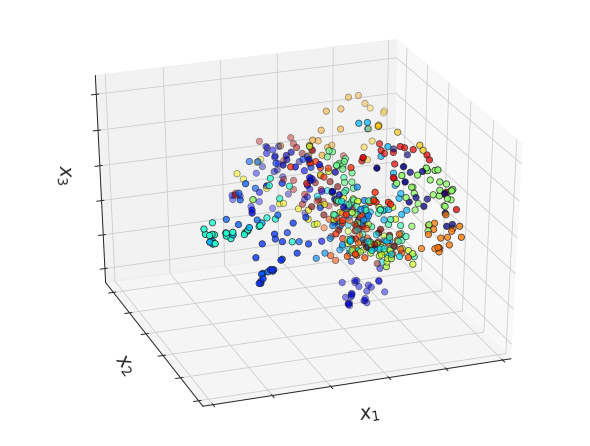

In [10]:
# Tenenbaum et al. "A Global Geometric Framework for Nonlinear Dimensionality Reduction" Science (2000)
X, y = load_gei(datapath, dim=dim, crop_person=crop_person)     
plot2d(Isomap(n_components=2).fit_transform(X),y)
plot3d(Isomap(n_components=3).fit_transform(X),y)

## Locally Linear Embedding (LLE)

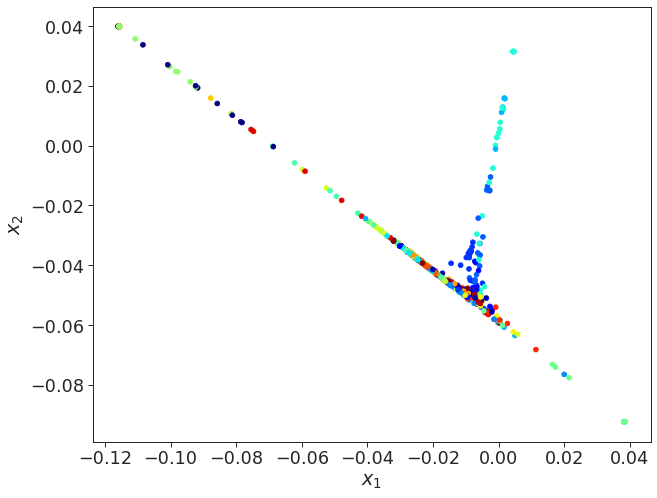

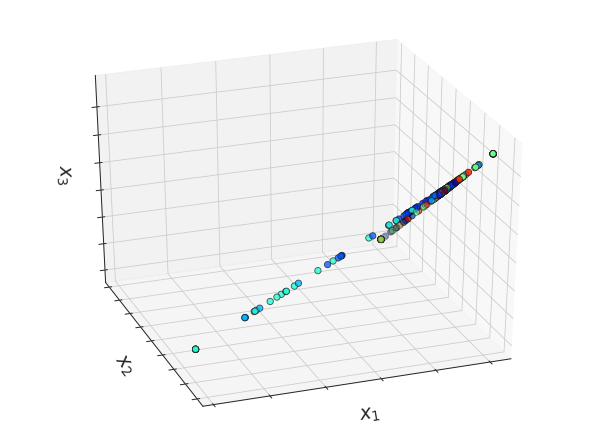

In [11]:
# Roweis et al. "Nonlinear dimensionality reduction by locally linear embedding." Science (2000)
X, y = load_gei(datapath, dim=dim, crop_person=crop_person)     
plot2d(LocallyLinearEmbedding(n_components=2).fit_transform(X),y)
plot3d(LocallyLinearEmbedding(n_components=3).fit_transform(X),y)

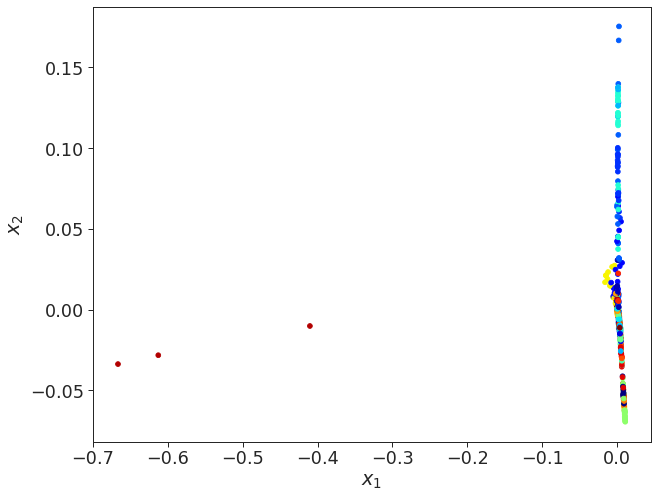

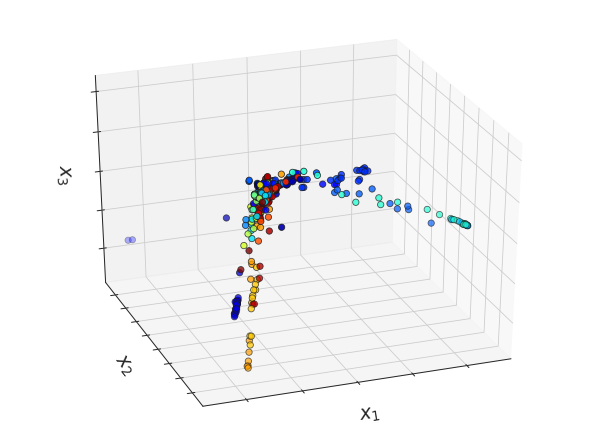

In [12]:
# MODIFIED locally linear embedding algorithm
# Zhang et al. "Modified Locally Linear Embedding Using Multiple Weights"
X, y = load_gei(datapath, dim=dim, crop_person=crop_person)     
plot2d(LocallyLinearEmbedding(n_components=2, method='modified').fit_transform(X),y)
plot3d(LocallyLinearEmbedding(n_components=3, method='modified').fit_transform(X),y)

# Training Models

In [26]:
# Kfold
n_splits = 3
cv = KFold(n_splits=n_splits, random_state=42, shuffle=True)  

In [27]:
dim = (64, 48)
crop_person = True

X, y = load_gei(datapath, dim=dim, crop_person=crop_person) 

In [28]:
# pipeline class is used as estimator to enable
# search over different model types

base_pipe = Pipeline([   
    ('reduction', PCA()),
    ('model', SVC())
])

## SVD

In [29]:
X, y = load_gei(datapath, dim=dim, crop_person=crop_person) 

knn_SVD = {
    'reduction': Categorical([TruncatedSVD(random_state=0),]),
    'reduction__n_components': Integer(2, 150),
    'model': Categorical([KNeighborsClassifier()]),    
    'model__n_neighbors': Integer(1,6),    
}

rf_SVD = {
    'reduction': Categorical([TruncatedSVD(random_state=0),]),
    'reduction__n_components': Integer(2, 150),
    'model': Categorical([RandomForestClassifier(max_depth=None, random_state=0, criterion='gini')]),    
    'model__n_estimators': Integer(100, 400),    
}

svc_SVD = {
    'reduction': Categorical([TruncatedSVD(random_state=0),]),
    'reduction__n_components': Integer(60, 80),
#     'model': Categorical([SVC(C=0.285873, degree=5.0, gamma=0.002535, kernel='linear', )]),
    'model': Categorical([SVC()]),
    'model__C': Real(1e-6, 1e+6, prior='log-uniform'),
    'model__gamma': Real(1e-6, 1e+1, prior='log-uniform'),
    'model__degree': Integer(1,8),
    'model__kernel': Categorical(['linear', 'poly', 'rbf']),
}

opt_SVD = BayesSearchCV(
    base_pipe,
    # (parameter space, # of evaluations)
    [(knn_SVD, 32), (rf_SVD, 512), (svc_SVD, 512),],
    cv=cv
).fit(X, y)

/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

In [30]:
df_SVD = df_results(opt_SVD)
df_SVD.to_csv('results_SVD.csv')
df_SVD

,model,model__n_neighbors,reduction,reduction__n_components,model__n_estimators,model__C,model__degree,model__gamma,model__kernel,mean_test_score,std_test_score,rank
551,"SVC(C=2456.506529411863, degree=7, gamma=0.000...",NaN,"TruncatedSVD(n_components=72, random_state=0)",72,NaN,2456.506529,7.0,0.000118,linear,0.881170,0.015995,1
939,"SVC(C=2456.506529411863, degree=7, gamma=0.000...",NaN,"TruncatedSVD(n_components=72, random_state=0)",72,NaN,1000000.000000,1.0,0.001132,poly,0.881170,0.015995,1
865,"SVC(C=2456.506529411863, degree=7, gamma=0.000...",NaN,"TruncatedSVD(n_components=72, random_state=0)",72,NaN,11391.865563,8.0,0.001394,linear,0.881170,0.015995,1
864,"SVC(C=2456.506529411863, degree=7, gamma=0.000...",NaN,"TruncatedSVD(n_components=72, random_state=0)",72,NaN,1000000.000000,8.0,0.000640,rbf,0.879342,0.008061,4
962,"SVC(C=2456.506529411863, degree=7, gamma=0.000...",NaN,"TruncatedSVD(n_components=72, random_state=0)",70,NaN,134.867658,7.0,0.000754,rbf,0.879342,0.004748,4
...,...,...,...,...,...,...,...,...,...,...,...,...
550,"SVC(C=2456.506529411863, degree=7, gamma=0.000...",NaN,"TruncatedSVD(n_components=72, random_state=0)",79,NaN,0.000004,5.0,1.037307,linear,0.038391,0.009038,1046
582,"SVC(C=2456.506529411863, degree=7, gamma=0.000...",NaN,"TruncatedSVD(n_components=72, random_state=0)",80,NaN,5.054028,5.0,0.000001,poly,0.038391,0.009038,1046
549,"SVC(C=2456.506529411863, degree=7, gamma=0.000...",NaN,"TruncatedSVD(n_components=72, random_state=0)",70,NaN,0.000009,3.0,0.814881,rbf,0.038391,0.009038,1046
546,"SVC(C=2456.506529411863, degree=7, gamma=0.000...",NaN,"TruncatedSVD(n_components=72, random_state=0)",73,NaN,0.000023,5.0,4.842281,rbf,0.038391,0.009038,1046


## PCA

In [31]:
0.864717X, y = load_gei(datapath, dim=dim, crop_person=crop_person) 

# single categorical value of 'model' parameter is
# sets the model class
# We will get ConvergenceWarnings because the problem is not well-conditioned.
# But that's fine, this is just an example.
# linsvc_search = {
#     'model': [LinearSVC(max_iter=1000)],
#     'model__C': (1e-6, 1e+6, 'log-uniform'),
# }

# explicit dimension classes can be specified like this

knn_PCA = {
    'reduction': Categorical([PCA(random_state=0),]),
    'reduction__n_components': Integer(2, 150),
    'model': Categorical([KNeighborsClassifier()]),    
    'model__n_neighbors': Integer(1,6),    
}

rf_PCA = {
    'reduction': Categorical([PCA(random_state=0),]),
    'reduction__n_components': Integer(2, 150),
    'model': Categorical([RandomForestClassifier(max_depth=None, random_state=0, criterion='gini')]),    
    'model__n_estimators': Integer(100, 400),    
}

svc_PCA = {
    'reduction': Categorical([PCA(random_state=0),]),
    'reduction__n_components': Integer(60, 80),
#     'model': Categorical([SVC(C=0.285873, degree=5.0, gamma=0.002535, kernel='linear', )]),
    'model': Categorical([SVC()]),
    'model__C': Real(1e-6, 1e+6, prior='log-uniform'),
    'model__gamma': Real(1e-6, 1e+1, prior='log-uniform'),
    'model__degree': Integer(1,8),
    'model__kernel': Categorical(['linear', 'poly', 'rbf']),
}

opt_PCA = BayesSearchCV(
    base_pipe,
    # (parameter space, # of evaluations)
    [(knn_PCA, 32), (rf_PCA, 512), (svc_PCA, 512),],
    cv=cv
).fit(X, y)

/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

In [32]:
df_PCA = df_results(opt_PCA)
df_PCA.to_csv('results_PCA.csv')
df_PCA

,model,model__n_neighbors,reduction,reduction__n_components,model__n_estimators,model__C,model__degree,model__gamma,model__kernel,mean_test_score,std_test_score,rank
728,"SVC(C=0.02061178762396307, degree=1, gamma=10....",NaN,"PCA(n_components=70, random_state=0)",70,NaN,1000000.000000,1.0,0.076781,poly,0.879342,0.013699,1
626,"SVC(C=0.02061178762396307, degree=1, gamma=10....",NaN,"PCA(n_components=70, random_state=0)",70,NaN,0.020612,1.0,10.000000,poly,0.879342,0.013699,1
750,"SVC(C=0.02061178762396307, degree=1, gamma=10....",NaN,"PCA(n_components=70, random_state=0)",70,NaN,1000000.000000,1.0,10.000000,poly,0.879342,0.013699,1
824,"SVC(C=0.02061178762396307, degree=1, gamma=10....",NaN,"PCA(n_components=70, random_state=0)",70,NaN,47203.117258,1.0,0.210392,poly,0.879342,0.013699,1
839,"SVC(C=0.02061178762396307, degree=1, gamma=10....",NaN,"PCA(n_components=70, random_state=0)",70,NaN,105229.607985,1.0,0.285655,poly,0.879342,0.013699,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1018,"SVC(C=0.02061178762396307, degree=1, gamma=10....",NaN,"PCA(n_components=70, random_state=0)",73,NaN,0.000001,1.0,0.006841,linear,0.038391,0.009038,1031
544,"SVC(C=0.02061178762396307, degree=1, gamma=10....",NaN,"PCA(n_components=70, random_state=0)",71,NaN,5.086733,5.0,0.000051,poly,0.038391,0.009038,1031
986,"SVC(C=0.02061178762396307, degree=1, gamma=10....",NaN,"PCA(n_components=70, random_state=0)",65,NaN,92.334395,1.0,0.000001,poly,0.038391,0.009038,1031
631,"SVC(C=0.02061178762396307, degree=1, gamma=10....",NaN,"PCA(n_components=70, random_state=0)",80,NaN,0.000001,8.0,0.000001,linear,0.038391,0.009038,1031


In [33]:
# 5 best knn models
df_PCA[df_PCA['model__n_neighbors']>0].head(5)

,model,model__n_neighbors,reduction,reduction__n_components,model__n_estimators,model__C,model__degree,model__gamma,model__kernel,mean_test_score,std_test_score,rank
24,KNeighborsClassifier(),1.0,PCA(random_state=0),46,NaN,NaN,NaN,NaN,NaN,0.760512,0.008715,716
27,KNeighborsClassifier(),1.0,PCA(random_state=0),48,NaN,NaN,NaN,NaN,NaN,0.758684,0.008418,718
18,KNeighborsClassifier(),1.0,PCA(random_state=0),61,NaN,NaN,NaN,NaN,NaN,0.755027,0.008701,726
11,KNeighborsClassifier(),1.0,PCA(random_state=0),71,NaN,NaN,NaN,NaN,NaN,0.755027,0.006375,726
10,KNeighborsClassifier(),1.0,PCA(random_state=0),70,NaN,NaN,NaN,NaN,NaN,0.755027,0.008701,726


In [34]:
# 5 best RF models
df_PCA[df_PCA['model__n_estimators']>0].head(5)

,model,model__n_neighbors,reduction,reduction__n_components,model__n_estimators,model__C,model__degree,model__gamma,model__kernel,mean_test_score,std_test_score,rank
390,RandomForestClassifier(random_state=0),NaN,PCA(random_state=0),39,324.0,NaN,NaN,NaN,NaN,0.773309,0.014225,476
525,RandomForestClassifier(random_state=0),NaN,PCA(random_state=0),40,231.0,NaN,NaN,NaN,NaN,0.771481,0.006405,477
503,RandomForestClassifier(random_state=0),NaN,PCA(random_state=0),40,231.0,NaN,NaN,NaN,NaN,0.771481,0.006405,477
504,RandomForestClassifier(random_state=0),NaN,PCA(random_state=0),40,231.0,NaN,NaN,NaN,NaN,0.771481,0.006405,477
505,RandomForestClassifier(random_state=0),NaN,PCA(random_state=0),40,231.0,NaN,NaN,NaN,NaN,0.771481,0.006405,477


In [35]:
# 5 best SVC models
df_PCA[df_PCA['model__C']>0].head(5)

,model,model__n_neighbors,reduction,reduction__n_components,model__n_estimators,model__C,model__degree,model__gamma,model__kernel,mean_test_score,std_test_score,rank
728,"SVC(C=0.02061178762396307, degree=1, gamma=10....",NaN,"PCA(n_components=70, random_state=0)",70,NaN,1000000.000000,1.0,0.076781,poly,0.879342,0.013699,1
626,"SVC(C=0.02061178762396307, degree=1, gamma=10....",NaN,"PCA(n_components=70, random_state=0)",70,NaN,0.020612,1.0,10.000000,poly,0.879342,0.013699,1
750,"SVC(C=0.02061178762396307, degree=1, gamma=10....",NaN,"PCA(n_components=70, random_state=0)",70,NaN,1000000.000000,1.0,10.000000,poly,0.879342,0.013699,1
824,"SVC(C=0.02061178762396307, degree=1, gamma=10....",NaN,"PCA(n_components=70, random_state=0)",70,NaN,47203.117258,1.0,0.210392,poly,0.879342,0.013699,1
839,"SVC(C=0.02061178762396307, degree=1, gamma=10....",NaN,"PCA(n_components=70, random_state=0)",70,NaN,105229.607985,1.0,0.285655,poly,0.879342,0.013699,1


## LDA

In [36]:
X, y = load_gei(datapath, dim=dim, crop_person=crop_person) 

In [37]:
LDA_params = {
    'reduction': Categorical([LDA(),]),
#     n_components cannot be larger than min(n_features, n_classes - 1).
    'reduction__n_components': Integer(15,  min(X.shape[1], np.unique(y).shape[0] - 1)),
}

In [38]:
knn_LDA = {
    **LDA_params,
    'model': Categorical([KNeighborsClassifier()]),    
    'model__n_neighbors': Integer(1,6),    
}

rf_LDA = {
    **LDA_params,
    'model': Categorical([RandomForestClassifier(max_depth=None, random_state=0, criterion='gini')]),    
    'model__n_estimators': Integer(100, 400),    
}

svc_LDA = {
    **LDA_params,
    'model': Categorical([SVC()]),
    'model__C': Real(1e-6, 1e+6, prior='log-uniform'),
    'model__gamma': Real(1e-6, 1e+1, prior='log-uniform'),
    'model__degree': Integer(1,8),
    'model__kernel': Categorical(['linear', 'poly', 'rbf']),
}

opt_LDA = BayesSearchCV(
    base_pipe,
    # (parameter space, # of evaluations),
    [(knn_LDA, 32), (rf_LDA, 512), (svc_LDA, 512),],
    cv=cv,
).fit(X, y)

/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

In [39]:
df_LDA = df_results(opt_LDA)
df_LDA.to_csv('results_LDA.csv')
df_LDA

,model,model__n_neighbors,reduction,reduction__n_components,model__n_estimators,model__C,model__degree,model__gamma,model__kernel,mean_test_score,std_test_score,rank
748,"SVC(C=0.011322576673683261, degree=6, gamma=3....",NaN,LinearDiscriminantAnalysis(n_components=16),16,NaN,0.011323,6.0,0.000034,linear,0.782450,0.017832,1
28,KNeighborsClassifier(),6.0,LinearDiscriminantAnalysis(n_components=16),16,NaN,NaN,NaN,NaN,NaN,0.778793,0.047099,2
2,KNeighborsClassifier(),5.0,LinearDiscriminantAnalysis(n_components=16),18,NaN,NaN,NaN,NaN,NaN,0.778793,0.008936,2
26,KNeighborsClassifier(),6.0,LinearDiscriminantAnalysis(n_components=16),15,NaN,NaN,NaN,NaN,NaN,0.778793,0.041503,2
27,KNeighborsClassifier(),6.0,LinearDiscriminantAnalysis(n_components=16),16,NaN,NaN,NaN,NaN,NaN,0.778793,0.047099,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1019,"SVC(C=0.011322576673683261, degree=6, gamma=3....",NaN,LinearDiscriminantAnalysis(n_components=16),23,NaN,2.954232,1.0,0.000042,poly,0.038391,0.009038,1043
756,"SVC(C=0.011322576673683261, degree=6, gamma=3....",NaN,LinearDiscriminantAnalysis(n_components=16),15,NaN,1000000.000000,4.0,10.000000,rbf,0.038391,0.009038,1043
553,"SVC(C=0.011322576673683261, degree=6, gamma=3....",NaN,LinearDiscriminantAnalysis(n_components=16),21,NaN,0.001935,5.0,0.000012,poly,0.038391,0.009038,1043
554,"SVC(C=0.011322576673683261, degree=6, gamma=3....",NaN,LinearDiscriminantAnalysis(n_components=16),23,NaN,0.000001,1.0,0.002160,linear,0.038391,0.009038,1043


In [40]:
# 5 best knn models
df_LDA[df_LDA['model__n_neighbors']>0].head(5)

,model,model__n_neighbors,reduction,reduction__n_components,model__n_estimators,model__C,model__degree,model__gamma,model__kernel,mean_test_score,std_test_score,rank
28,KNeighborsClassifier(),6.0,LinearDiscriminantAnalysis(n_components=16),16,NaN,NaN,NaN,NaN,NaN,0.778793,0.047099,2
2,KNeighborsClassifier(),5.0,LinearDiscriminantAnalysis(n_components=16),18,NaN,NaN,NaN,NaN,NaN,0.778793,0.008936,2
26,KNeighborsClassifier(),6.0,LinearDiscriminantAnalysis(n_components=16),15,NaN,NaN,NaN,NaN,NaN,0.778793,0.041503,2
27,KNeighborsClassifier(),6.0,LinearDiscriminantAnalysis(n_components=16),16,NaN,NaN,NaN,NaN,NaN,0.778793,0.047099,2
29,KNeighborsClassifier(),6.0,LinearDiscriminantAnalysis(n_components=16),16,NaN,NaN,NaN,NaN,NaN,0.778793,0.047099,2


In [41]:
# 5 best RF models
df_LDA[df_LDA['model__n_estimators']>0].head(5)

,model,model__n_neighbors,reduction,reduction__n_components,model__n_estimators,model__C,model__degree,model__gamma,model__kernel,mean_test_score,std_test_score,rank
257,RandomForestClassifier(random_state=0),NaN,LinearDiscriminantAnalysis(n_components=16),19,260.0,NaN,NaN,NaN,NaN,0.767824,0.004901,29
246,RandomForestClassifier(random_state=0),NaN,LinearDiscriminantAnalysis(n_components=16),19,260.0,NaN,NaN,NaN,NaN,0.767824,0.004901,29
261,RandomForestClassifier(random_state=0),NaN,LinearDiscriminantAnalysis(n_components=16),19,260.0,NaN,NaN,NaN,NaN,0.767824,0.004901,29
404,RandomForestClassifier(random_state=0),NaN,LinearDiscriminantAnalysis(n_components=16),19,260.0,NaN,NaN,NaN,NaN,0.767824,0.004901,29
248,RandomForestClassifier(random_state=0),NaN,LinearDiscriminantAnalysis(n_components=16),19,260.0,NaN,NaN,NaN,NaN,0.767824,0.004901,29


In [42]:
# 5 best SVC models
df_LDA[df_LDA['model__C']>0].head(5)

,model,model__n_neighbors,reduction,reduction__n_components,model__n_estimators,model__C,model__degree,model__gamma,model__kernel,mean_test_score,std_test_score,rank
748,"SVC(C=0.011322576673683261, degree=6, gamma=3....",NaN,LinearDiscriminantAnalysis(n_components=16),16,NaN,0.011323,6.0,0.000034,linear,0.782450,0.017832,1
792,"SVC(C=0.011322576673683261, degree=6, gamma=3....",NaN,LinearDiscriminantAnalysis(n_components=16),19,NaN,0.023743,7.0,10.000000,linear,0.776965,0.038042,7
1021,"SVC(C=0.011322576673683261, degree=6, gamma=3....",NaN,LinearDiscriminantAnalysis(n_components=16),19,NaN,1.362547,1.0,0.008832,poly,0.775137,0.015576,9
800,"SVC(C=0.011322576673683261, degree=6, gamma=3....",NaN,LinearDiscriminantAnalysis(n_components=16),23,NaN,5847.521591,3.0,0.000001,rbf,0.775137,0.022667,9
639,"SVC(C=0.011322576673683261, degree=6, gamma=3....",NaN,LinearDiscriminantAnalysis(n_components=16),21,NaN,0.019883,8.0,10.000000,linear,0.775137,0.035171,9


## (SVD or PCA) + LDA

In [43]:
base_pipe = Pipeline([   
    ('reduction_1', PCA()),
    ('reduction_2', LDA()),
    ('model', SVC())
])

In [44]:
X, y = load_gei(datapath, dim=dim, crop_person=crop_person) 

In [48]:
red_params = {
    'reduction_1': Categorical([PCA(random_state=0), TruncatedSVD(random_state=0)]),
#     n_components cannot be larger than min(n_features, n_classes - 1).
    'reduction_1__n_components': Integer(65,  90),
}

LDA_params = {
    'reduction_2': Categorical([LDA(),]),
#     n_components cannot be larger than min(n_features, n_classes - 1).
    'reduction_2__n_components': Integer(10,  min(X.shape[1], np.unique(y).shape[0] - 1)),
}

In [49]:
knn_COMB = {
    **red_params,
    **LDA_params,
    'model': Categorical([KNeighborsClassifier()]),    
    'model__n_neighbors': Integer(1,6),    
}

rf_COMB = {
    **red_params,
    **LDA_params,
    'model': Categorical([RandomForestClassifier(max_depth=None, random_state=0, criterion='gini')]),    
    'model__n_estimators': Integer(100, 400),    
}

svc_COMB = {
    **red_params,
    **LDA_params,
    'model': Categorical([SVC()]),
    'model__C': Real(1e-6, 1e+6, prior='log-uniform'),
    'model__gamma': Real(1e-6, 1e+1, prior='log-uniform'),
    'model__degree': Integer(1,8),
    'model__kernel': Categorical(['linear', 'poly', 'rbf']),
}

In [50]:
opt_COMB = BayesSearchCV(
    base_pipe,
    # (parameter space, # of evaluations),
    [(knn_COMB, 8), (rf_COMB, 128), (svc_COMB, 128),],
    cv=cv,
).fit(X, y)

/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

In [51]:
df_COMB = df_results(opt_COMB)
df_COMB.to_csv('results_COMB.csv')
df_COMB

,model,model__n_neighbors,reduction_1,reduction_1__n_components,reduction_2,reduction_2__n_components,model__n_estimators,model__C,model__degree,model__gamma,model__kernel,mean_test_score,std_test_score,rank
236,"SVC(C=0.06407936871344838, degree=1, gamma=1e-...",NaN,"PCA(n_components=65, random_state=0)",65,LinearDiscriminantAnalysis(n_components=23),23,NaN,0.064079,1.0,0.000001,linear,0.851920,0.004811,1
232,"SVC(C=0.06407936871344838, degree=1, gamma=1e-...",NaN,TruncatedSVD(random_state=0),65,LinearDiscriminantAnalysis(n_components=23),23,NaN,0.066732,8.0,0.000001,linear,0.846435,0.022724,2
223,"SVC(C=0.06407936871344838, degree=1, gamma=1e-...",NaN,"PCA(n_components=65, random_state=0)",65,LinearDiscriminantAnalysis(n_components=23),23,NaN,1.256656,8.0,0.005658,linear,0.844607,0.016816,3
219,"SVC(C=0.06407936871344838, degree=1, gamma=1e-...",NaN,"PCA(n_components=65, random_state=0)",65,LinearDiscriminantAnalysis(n_components=23),23,NaN,1000000.000000,1.0,0.000477,linear,0.842779,0.018550,4
175,"SVC(C=0.06407936871344838, degree=1, gamma=1e-...",NaN,"PCA(n_components=65, random_state=0)",65,LinearDiscriminantAnalysis(n_components=23),23,NaN,60.311237,6.0,0.000001,linear,0.842779,0.018550,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,"SVC(C=0.06407936871344838, degree=1, gamma=1e-...",NaN,TruncatedSVD(random_state=0),65,LinearDiscriminantAnalysis(n_components=23),23,NaN,1000000.000000,8.0,10.000000,rbf,0.038391,0.009038,253
150,"SVC(C=0.06407936871344838, degree=1, gamma=1e-...",NaN,TruncatedSVD(random_state=0),90,LinearDiscriminantAnalysis(n_components=23),10,NaN,0.000001,8.0,10.000000,linear,0.038391,0.009038,253
230,"SVC(C=0.06407936871344838, degree=1, gamma=1e-...",NaN,"PCA(n_components=65, random_state=0)",90,LinearDiscriminantAnalysis(n_components=23),23,NaN,0.000001,8.0,0.000001,rbf,0.038391,0.009038,253
153,"SVC(C=0.06407936871344838, degree=1, gamma=1e-...",NaN,"PCA(n_components=65, random_state=0)",90,LinearDiscriminantAnalysis(n_components=23),10,NaN,0.000001,1.0,0.000001,linear,0.038391,0.009038,253


## LLE

In [13]:
base_pipe = Pipeline([   
    ('reduction', PCA()),
    ('model', SVC())
])

In [30]:
X, y = load_gei(datapath, dim=dim, crop_person=crop_person) 

knn_LLE = {
    'reduction': Categorical([LocallyLinearEmbedding(random_state=0),]),
    'reduction__n_components': Integer(2, 150),
    'model': Categorical([KNeighborsClassifier()]),    
    'model__n_neighbors': Integer(1,6),    
}

rf_LLE = {
    'reduction': Categorical([LocallyLinearEmbedding(random_state=0),]),
    'reduction__n_components': Integer(2, 150),
    'model': Categorical([RandomForestClassifier(max_depth=None, random_state=0, criterion='gini')]),    
    'model__n_estimators': Integer(100, 400),    
}

svc_LLE = {
    'reduction': Categorical([LocallyLinearEmbedding(random_state=0),]),
    'reduction__n_components': Integer(60, 80),
#     'model': Categorical([SVC(C=0.285873, degree=5.0, gamma=0.002535, kernel='linear', )]),
    'model': Categorical([SVC()]),
    'model__C': Real(1e-6, 1e+6, prior='log-uniform'),
    'model__gamma': Real(1e-6, 1e+1, prior='log-uniform'),
    'model__degree': Integer(1,8),
    'model__kernel': Categorical(['linear', 'poly', 'rbf']),
}

opt_LLE = BayesSearchCV(
    base_pipe,
    # (parameter space, # of evaluations)
    [(knn_LLE, 32), (rf_LLE, 512), (svc_LLE, 512),],
    cv=cv
).fit(X, y)

/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

In [31]:
df_LLE = df_results(opt_LLE)
df_LLE.to_csv('results_LLE.csv')
df_LLE

,model,model__n_neighbors,reduction,reduction__n_components,model__n_estimators,model__C,model__degree,model__gamma,model__kernel,mean_test_score,std_test_score,rank
283,"SVC(C=1000000.0, degree=1, gamma=0.97182487891...",NaN,"LocallyLinearEmbedding(n_components=76, random...",76,NaN,1000000.000000,1.0,0.971825,linear,0.729433,0.013578,1
299,"SVC(C=1000000.0, degree=1, gamma=0.97182487891...",NaN,"LocallyLinearEmbedding(n_components=76, random...",76,NaN,2310.204248,1.0,10.000000,linear,0.725777,0.007431,2
107,KNeighborsClassifier(),1.0,LocallyLinearEmbedding(random_state=0),150,NaN,NaN,NaN,NaN,NaN,0.723949,0.017646,3
89,KNeighborsClassifier(),1.0,LocallyLinearEmbedding(random_state=0),149,NaN,NaN,NaN,NaN,NaN,0.723949,0.017646,3
84,KNeighborsClassifier(),1.0,LocallyLinearEmbedding(random_state=0),150,NaN,NaN,NaN,NaN,NaN,0.723949,0.017646,3
...,...,...,...,...,...,...,...,...,...,...,...,...
321,"SVC(C=1000000.0, degree=1, gamma=0.97182487891...",NaN,"LocallyLinearEmbedding(n_components=76, random...",80,NaN,3605.506758,8.0,0.000001,rbf,0.038391,0.009038,370
267,"SVC(C=1000000.0, degree=1, gamma=0.97182487891...",NaN,"LocallyLinearEmbedding(n_components=76, random...",60,NaN,0.000503,1.0,8.932100,poly,0.038391,0.009038,370
325,"SVC(C=1000000.0, degree=1, gamma=0.97182487891...",NaN,"LocallyLinearEmbedding(n_components=76, random...",80,NaN,0.069870,1.0,0.000001,linear,0.038391,0.009038,370
296,"SVC(C=1000000.0, degree=1, gamma=0.97182487891...",NaN,"LocallyLinearEmbedding(n_components=76, random...",70,NaN,0.000001,2.0,4.968170,rbf,0.038391,0.009038,370


The methods below did not run!

## Isomap Embedding

In [ ]:
X, y = load_gei(datapath, dim=dim, crop_person=crop_person) 

knn_ISO = {
    'reduction': Categorical([Isomap(),]),
    'reduction__n_components': Integer(2, 150),
    'model': Categorical([KNeighborsClassifier()]),    
    'model__n_neighbors': Integer(1,6),    
}

rf_ISO = {
    'reduction': Categorical([Isomap(),]),
    'reduction__n_components': Integer(2, 150),
    'model': Categorical([RandomForestClassifier(max_depth=None, random_state=0, criterion='gini')]),    
    'model__n_estimators': Integer(100, 400),    
}

svc_ISO = {
    'reduction': Categorical([Isomap(),]),
    'reduction__n_components': Integer(60, 80),
#     'model': Categorical([SVC(C=0.285873, degree=5.0, gamma=0.002535, kernel='linear', )]),
    'model': Categorical([SVC()]),
    'model__C': Real(1e-6, 1e+6, prior='log-uniform'),
    'model__gamma': Real(1e-6, 1e+1, prior='log-uniform'),
    'model__degree': Integer(1,8),
    'model__kernel': Categorical(['linear', 'poly', 'rbf']),
}

opt_ISO = BayesSearchCV(
    base_pipe,
    # (parameter space, # of evaluations)
    [(knn_ISO, 128), (rf_ISO, 128), (svc_ISO, 128),],
    cv=cv
).fit(X, y)

/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

In [ ]:
df_ISO = df_results(opt_ISO)
df_ISO.to_csv('results_ISO.csv')
df_ISO

## T-SNE

In [ ]:
X, y = load_gei(datapath, dim=dim, crop_person=crop_person) 0.767824

In [ ]:
TSNE_params = {
    'reduction': Categorical([TSNE(),]),
#     n_components cannot be larger than min(n_features, n_classes - 1).
    'reduction__n_components': Integer(2,  15),
}

In [ ]:
knn_TSNE = {
    **TSNE_params,
    'model': Categorical([KNeighborsClassifier()]),    
    'model__n_neighbors': Integer(1,6),    
}

rf_TSNE = {
    **TSNE_params,
    'model': Categorical([RandomForestClassifier(max_depth=None, random_state=0, criterion='gini')]),    
    'model__n_estimators': Integer(100, 400),    
}

svc_TSNE = {
    **TSNE_params,
    'model': Categorical([SVC()]),
    'model__C': Real(1e-6, 1e+6, prior='log-uniform'),
    'model__gamma': Real(1e-6, 1e+1, prior='log-uniform'),
    'model__degree': Integer(1,8),
    'model__kernel': Categorical(['linear', 'poly', 'rbf']),
}

opt_TSNE = BayesSearchCV(
    base_pipe,
    # (parameter space, # of evaluations),
    [(knn_TSNE, 64), (rf_TSNE, 64), (svc_TSNE, 64),],
    cv=cv,
).fit(X, y)

In [ ]:
# issue on github: https://github.com/scikit-learn/scikit-learn/issues/16710